# Exercise Session 0: Getting Started with Scientific Python for Time-series Data

The goals of this exercise are:
* getting started with Python for time-series manipulation
* getting familiar with the basic time-series  manipulation functions
* implementing some simple real-world anomaly dection algorithms

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew

from IPython.display import Audio

import os

import warnings
warnings.filterwarnings('ignore')

#Set up default settings for figures
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['image.cmap'] = 'gray'

### Global Variables

In [2]:
BASE_DIR = '.'
DATA_FOLDER = os.path.join(BASE_DIR,'Data')
REP ="spec" 

SR = 16000 # SAMPLING RATE

EPSILON = 1e-6

# Exercise 1: Basic time-series data analysis

## a) Read and plot time-series data (signal)

### Time Series Data: Audio Signals

Many real-world data are represented as time series. One intuitive example is an audio signal, which is defined by a specific sampling rate.

### Sampling Rate

The sampling rate refers to how many snapshots (samples) are taken in one second. It's usually measured in:
- Samples per second
- Hertz (Hz)

For example, if you have a sampling rate of 100 Hz, you're taking 100 samples of the signal every second.

### Reading and Visualizing Audio Signals

To read and display an audio signal (e.g., "slider_1.wav" or "fan_1.wav"), we can use the `librosa` library. Here's a Python script that demonstrates how to load an audio file and visualize its waveform:

In [3]:
# complete the lines with ...

def load_data(path2data, sr=16000):
    """
    Load an audio file and return the audio time series.

    This function uses librosa to read an audio file and resample it to the specified sampling rate.

    Parameters:
    -----------
    path2data : str
        The file path to the audio file to be loaded.
    sr : int, optional
        The target sampling rate. If specified, the loaded audio will be resampled to this rate.
        Default is 16000 Hz.

    Returns:
    --------
    y : np.ndarray
        The audio time series as a numpy array.
    sr : int
        The sampling rate of the audio.

    Raises:
    -------
    FileNotFoundError
        If the specified audio file does not exist.
    RuntimeError
        If there's an error in loading the audio file.

    Example:
    --------
    >>> audio_path = "path/to/your/audio/file.wav"
    >>> y, sr = load_data(audio_path)
    >>> print(f"Loaded audio with {len(y)} samples at {sr} Hz")

    Notes:
    ------
    - This function supports various audio formats including WAV, MP3, OGG, etc., as supported by librosa.
    - The audio is automatically resampled to the specified sampling rate (default 16000 Hz).
    - Mono audio is returned even if the input is stereo.
    """
    try:
        if not os.path.exists(path2data):
            raise FileNotFoundError(f"The file {path2data} does not exist.")
        
        y, sr = ...
        
        print(f"Successfully loaded audio file: {path2data}")
        print(f"Audio length: {len(y) / sr:.2f} seconds")
        print(f"Sampling rate: {sr} Hz")
        
        return y, sr
    
    except librosa.LibrosaError as e:
        raise RuntimeError(f"Error loading audio file: {e}")

In [4]:
def plot_raw_signal(y, key, sr=22050, duration=10):
    """
    Plot the raw time-domain representation of an audio signal.

    This function creates a plot of the amplitude of the audio signal over time.

    Parameters:
    -----------
    y : np.ndarray
        The input audio time series as a numpy array.
    key : str
        A string identifier for the signal, used in the plot title.
    sr : int, optional
        The sampling rate of the audio signal (default is 22050 Hz).
    duration : float, optional
        The duration of the signal to plot in seconds (default is 10 seconds).

    Returns:
    --------
    None
        This function doesn't return any value. It displays the plot directly.

    Example:
    --------
    >>> import numpy as np
    >>> sr = 22050
    >>> y = np.sin(2 * np.pi * 440 * np.linspace(0, 1, sr))  # 1 second of 440 Hz sine wave
    >>> plot_raw_signal(y, 'Sine Wave', sr=sr, duration=1)
    """
    # Calculate the time array
    t = np.linspace(0, duration, num=min(len(y), int(duration * sr)), endpoint=False)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(t, y[:len(t)], color='C0')

    # Set title and labels
    ax.set_title(f'Raw Signal: {key}')
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Amplitude")

    # Set x-axis limits
    ax.set_xlim(0, duration)

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [5]:
# function to set the path to the desired machine
def choose_machine(machine='slider', machine_name='1'):
    """
    Choose a machine and return its path.

    Parameters:
    machine (str): Type of machine. Must be either 'fan' or 'slider'. Default is 'slider'.
    machine_name (str): Identifier for the machine. Must be '1', '2', or 'anomaly'. Default is '1'.

    Returns:
    str: Path to the chosen machine's data file.

    Raises:
    ValueError: If invalid machine or machine_name is provided.
    FileNotFoundError: If the data file for the chosen machine is not found.
    """
    valid_machines = ['fan', 'slider']
    valid_machine_names = ['1', '2', 'anomaly']

    if machine not in valid_machines:
        raise ValueError(f"Invalid machine. Must be one of {valid_machines}")
    
    if machine_name not in valid_machine_names:
        raise ValueError(f"Invalid machine_name. Must be one of {valid_machine_names}")

    chosen_machine = f"{machine}_{machine_name}"
    print(f'YOU CHOSE: {chosen_machine}')

    # Use os.path.join for all path operations to ensure cross-platform compatibility
    path_chosen_machine = os.path.join(DATA_FOLDER, f"{chosen_machine}.wav")
    
    if not os.path.isfile(path_chosen_machine):
        raise FileNotFoundError(f"Data file for {chosen_machine} not found at {path_chosen_machine}")

    return path_chosen_machine

YOU CHOSE: slider_anomaly
Successfully loaded audio file: .\Data\slider_anomaly.wav
Audio length: 10.00 seconds
Sampling rate: 16000 Hz


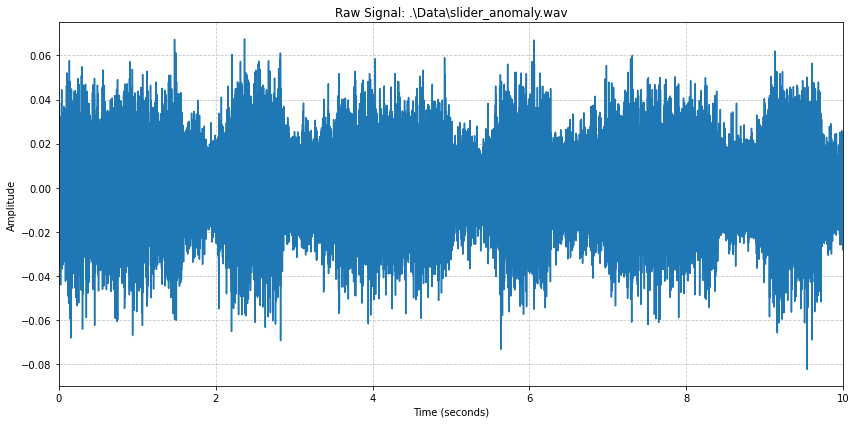

In [6]:
# load and visualize data
PATH2MACHINE_DATA = choose_machine(machine='slider',machine_name='anomaly')
y,sr = load_data(PATH2MACHINE_DATA)
plot_raw_signal(y,PATH2MACHINE_DATA)

In [7]:
Audio(data=y,rate=SR)

## b) Perform basic signal analysis in frequency domain
### Fourier Transform and Frequency Domain Analysis

The Fourier transform (FT) is a powerful mathematical tool that allows us to represent a time series in the frequency domain. This transformation is crucial in signal processing, as it reveals information about the signal that may not be apparent in the time domain.

#### Key Concepts:

1. **Decomposition**: The FT breaks down a signal into its constituent frequencies.
2. **Time to Frequency Conversion**: It transforms a time-domain signal into a frequency-domain representation.
3. **Spectrum Analysis**: It enables us to visualize the strength of different frequency components in the signal.

### Discrete Fourier Transform (DFT)

In digital signal processing, we use the Discrete Fourier Transform (DFT), which is tailored for discrete (sampled) signals.

**Output of DFT**:
- A complex-valued array of the same length as the input signal.
- Each value corresponds to the amplitude and phase of a particular frequency component in the signal.

### Implementation with Fast Fourier Transform (FFT)

In practice, we use the Fast Fourier Transform (FFT) algorithm, an efficient method to compute the DFT. Here's how to compute the FFT of a signal `y` using NumPy:

In [8]:
## Complete for calculating the fourier transform of y
yf = ... # Compute the Discrete Fourier Transform of y

### Creating Frequency Array for FFT Results

When working with Fourier transforms, it's crucial to understand how to interpret the frequency values associated with the transform results. The NumPy function `np.fft.fftfreq()` is commonly used for this purpose.

#### `np.fft.fftfreq(len(y))`

**Description**: This function creates an array of frequency values corresponding to the FFT output.

**Output**:
- Returns an array of length N (same as the input signal).
- Provides the frequency bins for each element in the FFT output.
- Values are normalized and represent frequency in "cycles per sample."

In [9]:
freq = np.fft.fftfreq(len(y)) 

### Visualizing the Magnitude Spectrum

We use the calculated frequency array to visualize the Magnitude Spectrum by plotting the `freq` with respect to `yf` (Fourier transform).

To visualize the frequency content of our signal, we can plot the magnitude spectrum:

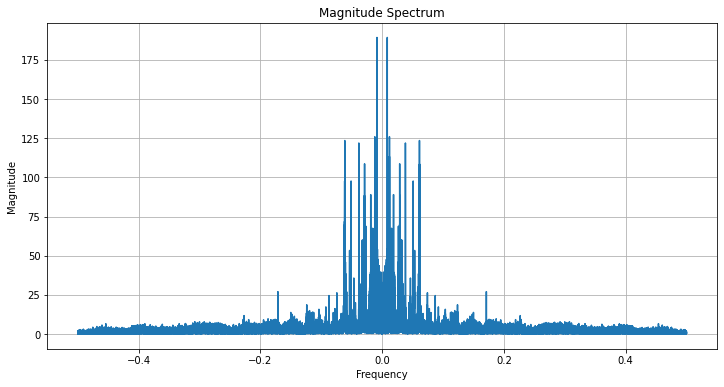

In [10]:
#Visualization
plt.plot(freq, np.abs(yf))
plt.title("Magnitude Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

# Optional: Uncomment the following lines to visualize only the positive part of the spectrum
# n = len(freq)
# plt.xlim(0, freq[n//2])  # Limit x-axis to positive frequencies
# plt.plot(freq[:n//2], np.abs(yf[:n//2]))  # Plot only the positive half

### Interpreting the Magnitude Spectrum

The magnitude spectrum plot reveals several key insights about your signal:

- **Peaks**: Prominent peaks indicate dominant frequencies in your signal.
- **Symmetry**: The plot is symmetric around the center, reflecting both positive and negative frequencies in the Fourier Transform.
- **Frequency Range**: 
  - X-axis shows normalized frequencies.
  - To convert to Hz, multiply by your sampling rate.
- **Magnitude**: Y-axis represents the strength or amplitude of each frequency component.

#### Key Observations:
- Highest peaks correspond to the most significant frequency components.
- Lower magnitude frequencies contribute less to the overall signal.
- For practical analysis, focus on the positive half of the frequency spectrum (right side of the center).

## Short Time Fourier Transform (STFT)

The Short Time Fourier Transform (STFT) is a powerful method for analyzing the frequency content of signals that vary over time. Unlike the standard Fourier Transform, which provides a global frequency representation, the STFT offers a time-localized frequency analysis.

### Key Features

- **Time-Varying Analysis**: Ideal for non-stationary signals where frequency content changes over time.
- **Windowing Technique**: Analyzes small, overlapping chunks (or "windows") of the signal.
- **Local Frequency Representation**: Computes the Fourier Transform for each windowed segment.

### How STFT Works

1. **Windowing**: 
   - The signal is multiplied by a window function (e.g., Hamming or Hanning window).
   - This window slides across the signal, creating overlapping segments.

2. **Fourier Transform**: 
   - Each windowed segment undergoes Fourier Transform.
   - This provides a frequency spectrum for that specific time segment.

3. **Time-Frequency Representation**: 
   - Results in a 2D representation:
     - One dimension represents time (window position)
     - The other dimension represents frequency
   - The magnitude or power of the result shows the strength of each frequency component at each point in time.

### Advantages

- Reveals how frequency content of a signal changes over time.
- Particularly useful for analyzing complex, time-varying signals.
- Provides a balance between time and frequency resolution.

### Applications

- Speech and audio processing
- Vibration analysis
- Radar signal processing
- Biomedical signal analysis

## Spectrogram

A spectrogram is a visual representation of the Short Time Fourier Transform (STFT), offering a comprehensive view of a signal's frequency content over time.

### Key Features

- **2D Plot**: 
  - X-axis: Time
  - Y-axis: Frequency
  - Color/Intensity: Magnitude or power of the STFT

- **Heat Map Visualization**: Shows how frequency content evolves over time
  - Brighter colors or higher intensity indicate stronger frequency components
  - Allows easy identification of dominant frequencies at specific time intervals

### Advantages

- **Non-Stationary Signal Analysis**: Ideal for signals whose frequency content changes over time
- **Intuitive Visualization**: Provides a clear, visual representation of complex signal characteristics
- **Pattern Recognition**: Facilitates identification of recurring patterns or anomalies in the signal

### Applications

- Audio and speech processing
- Music analysis
- Seismology
- Radar and sonar systems
- Biomedical signal analysis (e.g., EEG, ECG)

### Interpretation

- Horizontal lines indicate constant frequency components
- Vertical lines suggest sudden, broadband frequency changes
- Curved lines may represent frequency modulation or pitch changes

By providing a time-frequency-intensity representation, spectrograms offer powerful insights into the dynamic behavior of signals, making them an essential tool in various fields of signal processing and analysis.

### Short-Time Fourier Transform (STFT) with Librosa

#### Function Signature
**x = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)**
#### Input Parameters

- **y**: The input audio signal (usually a 1D array of amplitude values).
- **n_fft**: The number of data points used in each block for the FFT (Fast Fourier Transform). Default is 1600.
- **hop_length**: The number of samples between successive frames (i.e., how much the window shifts for the next chunk of data). Default is 1600.

#### Output

The function returns `x`, a 2D complex-valued array:

- **Dimensions**:
  - Rows: Half of n_fft plus one (representing frequency bins)
  - Columns: Determined by the audio length and hop_length (representing time frames)
- **Values**: Each entry in x gives amplitude and phase for a frequency at a specific time.

#### Visualization of output x

1. Often visualized by magnitude (`np.abs(x)`) on a logarithmic scale, with time on the x-axis and frequency on the y-axis.
2. Convert to decibels (dB):
   **20 * np.log10(np.abs(x) + epsilon)**
   
3. Use Librosa's specshow function to create a spectrogram:
**librosa.display.specshow(20 * np.log10(np.abs(x) + epsilon),
                         sr=SR,
                         hop_length=hop_length,
                         x_axis="time",
                         y_axis="linear",
                         ax=axs)**



In [29]:
##complete the function for ploting the Spectrogram using the short fourier transform of an audio file 
def plot_spectrogram(y, key, sr=22050, n_fft=1600, hop_length=400, window='hann', epsilon=1e-10):
    """
    Plot the spectrogram of an audio signal using Short-Time Fourier Transform (STFT).

    This function computes and displays the spectrogram of the input audio signal
    using librosa's STFT implementation. The spectrogram is plotted on a logarithmic scale.

    Parameters:
    -----------
    y : np.ndarray
        The input audio time series as a numpy array.
    key : str
        A string identifier for the signal, used in the plot title.
    sr : int, optional
        The sampling rate of the audio signal (default is 22050 Hz).
    n_fft : int, optional
        The length of the windowed signal after padding with zeros (default is 1600).
        This parameter determines the frequency resolution of the spectrogram.
        Larger values increase frequency resolution but decrease time resolution.
    hop_length : int, optional
        Number of audio samples between adjacent STFT columns (default is 400).
        Smaller values increase time resolution at the expense of more computation.
        A common choice is n_fft // 4.
    window : str, optional
        The windowing function to use (default is 'hann').
        Other options include 'hamming', 'blackman', etc.
    epsilon : float, optional
        Small value added to the spectrogram before taking the logarithm,
        to avoid log(0) errors (default is 1e-10).

    Returns:
    --------
    None
        This function doesn't return any value. It displays the plot directly.

    Notes:
    ------
    - The spectrogram is computed using the Short-Time Fourier Transform (STFT).
    - The magnitude of the STFT is converted to a decibel scale for better visualization.
    - The color scale represents the power of the signal at each time-frequency point.
    - Brighter colors indicate higher power, while darker colors indicate lower power.

    Example:
    --------
    >>> import numpy as np
    >>> import librosa
    >>> y, sr = librosa.load('path_to_audio_file.wav')
    >>> plot_spectrogram(y, 'Example Audio', sr=sr)
    """
    # Input validation
    if not isinstance(y, np.ndarray):
        raise ValueError("Input signal must be a numpy array")
    if y.ndim != 1:
        raise ValueError("Input signal must be a 1D array")

    # Compute STFT
    spec = ... # librosa function for stft calculation

    # Convert to dB scale
    spec_db = 20 * np.log10(np.abs(spec) + EPSILON)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    img = ... #librosa function for displaying the spectogram

    # Add colorbar
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

    # Set title and labels
    ax.set_title(f'Spectrogram: {key}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.show()

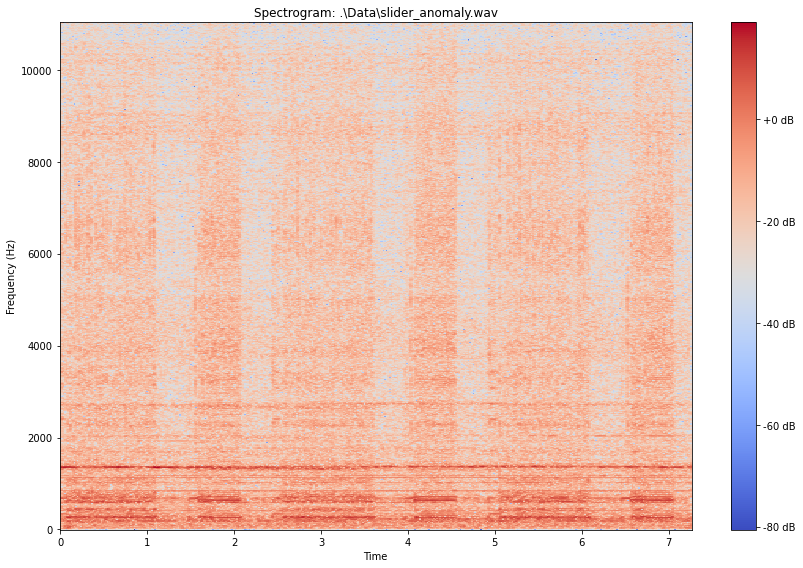

In [30]:
plot_spectrogram(y,PATH2MACHINE_DATA)

# Mel Spectrogram Representation

## Introduction
A Mel Spectrogram is another way to represent a time series in the Fourier domain. It offers a visual representation of the frequency content of a signal as it varies with time, with frequencies converted to the Mel scale.

## Key Concepts

### Mel Scale
- The human ear perceives different frequencies non-linearly.
- Lower frequencies are perceived with more detail than higher frequencies.
- The Mel scale is a perceptual scale of pitches that approximates the ear's response to different frequencies.

### Creating a Mel Spectrogram
1. Compute the spectrogram of a signal.
2. Group the frequencies of that spectrogram into Mel frequency bands.
3. This process effectively warps the frequency scale to better match human hearing.

## Implementation
To compute the Mel Spectrogram representation of a signal `y`, you can use the `librosa.feature.melspectrogram()` function from the Librosa library.

In [52]:
##complete the function for ploting the Mel-Spectrogram using the short fourier transform of an audio file 

def plot_mel_spectrogram(y, key, sr=22050, n_fft=1600, hop_length=1600, epsilon=1e-10):
    """
    Plot the Mel Spectrogram of an audio signal.

    This function computes and displays the Mel Spectrogram of the input audio signal
    using librosa. The spectrogram is plotted on a logarithmic scale.

    Parameters:
    -----------
    y : np.ndarray
        The input audio time series as a numpy array.
    key : str
        A string identifier for the signal, used in the plot title.
    sr : int, optional
        The sampling rate of the audio signal (default is 22050 Hz).
    n_fft : int, optional
        The length of the windowed signal after padding with zeros (default is 1600).
        The number of rows in the spectrogram will be (1 + n_fft/2).
    hop_length : int, optional
        Number of audio samples between adjacent STFT columns (default is 1600).
    epsilon : float, optional
        Small value added to the spectrogram before taking the logarithm,
        to avoid log(0) errors (default is 1e-10).

    Returns:
    --------
    None
        This function doesn't return any value. It displays the plot directly.

    Example:
    --------
    >>> import numpy as np
    >>> y = np.random.randn(22050 * 5)  # 5 seconds of random noise
    >>> plot_mel_spectrogram(y, 'Random Noise')
    """
    # Compute the Mel Spectrogram 
    mel_spec = ...  # librosa function for melspectogram calculation
    
    # Convert to log scale
    mel_spec_db = 20 * np.log10(np.abs(mel_spec) + EPSILON)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    img = ... # librosa function to visualize the mel spectogram
    
    # Add colorbar
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    # Set title and labels
    ax.set_title(f'Mel-Spectrogram: {key}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Frequency')

    plt.tight_layout()
    plt.show()

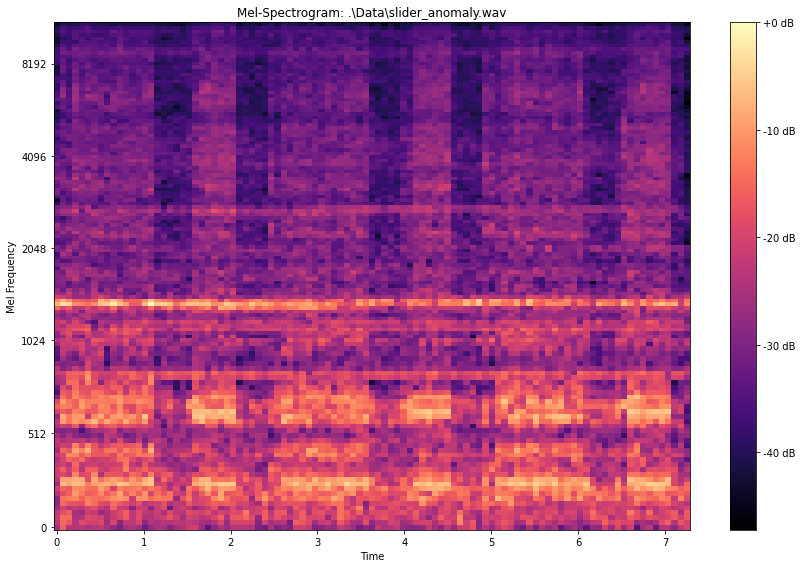

In [55]:
plot_mel_spectrogram(y,PATH2MACHINE_DATA)

# Exercise 2: Compute some statistics of the signal

## Statistical Moments for Signal Summarization

Statistical moments provide a compact way to describe the characteristics of a signal. These features can be particularly useful for machine learning tasks, as they capture important aspects of the signal's distribution without requiring the full time series data.

## Key Statistical Moments

1. **Mean (1st moment)**
   - Represents the average value of the signal
   - Indicates the central tendency

2. **Standard Deviation (2nd moment)**
   - Measures the spread or dispersion of the signal values
   - Indicates the typical deviation from the mean

3. **Skewness (3rd moment)**
   - Measures the asymmetry of the signal's distribution
   - Positive skew: tail on right side
   - Negative skew: tail on left side

4. **Kurtosis (4th moment)**
   - Measures the "tailedness" of the distribution
   - Higher kurtosis indicates more extreme outliers

## Additional Useful Statistics

- **Median**: The middle value when the signal is ordered
- **Mode**: The most frequently occurring value
- **Range**: The difference between the maximum and minimum values
- **Histogram**: A graphical representation of the distribution of signal values
  - Provides a visual summary of the data
  - Helps in identifying the shape, central tendency, and spread of the distribution
  - Useful for detecting multimodality, skewness, and outliers

## Importance in Machine Learning

These statistical features are valuable for machine learning because they:
- Provide a fixed-size input regardless of the original signal length
- Capture different aspects of the signal's distribution
- Are often computationally efficient to calculate
- Can help in distinguishing between different types of signals or events

## Using Histograms in Signal Analysis

Histograms are particularly useful in signal analysis for several reasons:
- They offer a visual representation of the signal's probability distribution
- They can reveal patterns or anomalies that may not be apparent from summary statistics alone
- They help in comparing the distributions of different signals
- They can assist in identifying appropriate thresholds for signal classification or anomaly detection
- The shape of the histogram can provide insights into the underlying processes generating the signal

When analyzing signals, comparing histograms alongside other statistical moments can provide a more comprehensive understanding of the signal's characteristics and how different signals or events may be distinguished from one another.

* Computer the mean of "y" using e.g. function ```np.mean()``` function.</li>

In [36]:
##complete the function to return the mean of the signal
def mean_signal(y):
    mean = ...
    return mean

* Computer the standard-deviation of "y" using e.g. function ```np.std()``` function.</li>

In [37]:
##complete the function to return the mean of the signal
def std_signal(y):
    std = ...
    return std

* Computer the pic to pic variation of "y" using e.g. function ```np.min()```  and ```np.max()``` function.</li>

In [38]:
##complete the function to distance between the min and max value of the signal
def pic_2_pic_signal(y):
    min_value = y.min()
    max_value = y.max()
    pic_2_pic = ...
    return pic_2_pic

* Computer the third moment of "y" using e.g. function ```scipy.stats.skew()``` function.</li>

In [39]:
##complete the function
def asymetry_signal(y):
    asymetry = ... # imported earlier from scipy.stats : from scipy.stats import skew
    return asymetry

* Computer the fourth moment of "y" using e.g. function ```scipy.stats.kurtosis()``` function.</li>

In [40]:
##complete the function
def kurtosis_signal(y):
    kurt = ... # imported earlier from scipy.stats : from scipy.stats import kurtosis
    return kurt

* Computer and plot the histogram of "y" using e.g. function ```plt.hist()``` function.</li>

In [41]:
def plot_hist_signal(y, key, bins=100, range=None, density=False):
    """
    Plot a histogram of the input signal.

    This function creates a histogram plot of the input signal, which can be useful
    for visualizing the distribution of amplitude values in the signal.

    Parameters:
    -----------
    y : np.ndarray
        The input signal as a numpy array.
    key : str
        A string identifier for the signal, used in the plot title.
    bins : int or sequence, optional
        If an integer, it defines the number of equal-width bins in the range.
        If a sequence, it defines the bin edges (default is 100).
    range : tuple or None, optional
        The lower and upper range of the bins. If not provided, range is (y.min(), y.max()).
        Values outside the range are ignored (default is None).
    density : bool, optional
        If True, draw and return a probability density: each bin will display the bin's 
        raw count divided by the total number of counts and the bin width (default is False).

    Returns:
    --------
    None
        This function doesn't return any value. It displays the plot directly.

    Notes:
    ------
    - The histogram shows the distribution of amplitude values in the signal.
    - The x-axis represents the amplitude bins, and the y-axis represents the count (or density).
    - This visualization can be useful for understanding the dynamic range and characteristics of the signal.

    Example:
    --------
    >>> import numpy as np
    >>> y = np.random.normal(0, 1, 1000)  # Generate random signal
    >>> plot_hist_signal(y, 'Random Normal Distribution')
    """
    # Input validation
    if not isinstance(y, np.ndarray):
        raise ValueError("Input signal must be a numpy array")
    if y.ndim != 1:
        raise ValueError("Input signal must be a 1D array")

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot histogram
    n, bins, patches = ax.hist(y, bins=bins, range=range, density=density, 
                               edgecolor='black', alpha=0.7)

    # Set title and labels
    ax.set_title(f'Histogram: {key}')
    ax.set_xlabel("Amplitude")
    ax.set_ylabel("Count" if not density else "Density")

    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add some statistics to the plot
    ax.text(0.95, 0.95, f'Mean: {np.mean(y):.6f}\nStd: {np.std(y):.6f}',
            transform=ax.transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Exercise 3: Connected Components and Signal Analysis

## Objective
Compute and analyze statistical moments of signals to distinguish between normal and abnormal patterns. This approach serves as a crucial first step in signal analysis and anomaly detection, providing insights into signal characteristics that can be used for further processing or machine learning tasks.

## Background
Connected components in signal processing refer to continuous segments of a signal that share similar properties. These components can be identified by thresholding the signal or using more advanced segmentation techniques. By analyzing the statistical properties of these components, we can often differentiate between normal and abnormal signals.

## Steps

### 1. Visualize all signals together
Plot all signals (normal and abnormal) on the same graph to visually compare their characteristics. This step helps in identifying obvious differences in amplitude, frequency, or overall pattern.

### 2. Visualize Spectrogram plots of the signal
Create spectrogram plots to represent the signal's frequency content over time. Spectrograms provide insights into:
- Frequency components present in the signal
- How these frequencies change over time
- Intensity of different frequency components

This visualization can reveal patterns or anomalies that may not be apparent in the time domain representation.

### 3. Visualize Mel Spectrogram plots of the signal
Generate Mel Spectrogram plots, which are similar to regular spectrograms but use the Mel scale. The Mel scale is a perceptual scale of pitches, designed to more closely represent human auditory perception. This is particularly useful for:
- Audio signal analysis
- Speech recognition tasks
- Identifying perceptually significant frequency patterns

### 4. Analyze Connected Components
For each connected component in both normal and abnormal signals, compute the following statistical measures:

- **Mean**: Average value of the component, indicating its central tendency
- **Standard Deviation (Std)**: Measure of the component's variability or dispersion
- **Peak to Peak**: Difference between the maximum and minimum values, indicating the component's range
- **Kurtosis**: Measure of the "tailedness" of the component's distribution, useful for detecting outliers or unusual events
- **Skewness**: Measure of asymmetry in the component's distribution
- **Histogram**: Visual representation of the distribution of values within the component

These statistics provide a comprehensive view of each component's characteristics and can be used to identify unusual patterns or anomalies.

### 5. Compare Normal vs Abnormal Signals
Use the computed statistics to differentiate between normal and abnormal signals. This comparison can involve:

- Calculating overall statistics for each full signal (normal and abnormal)
- Comparing the distribution of component statistics between normal and abnormal signals
- Identifying threshold values for each statistic that best separate normal from abnormal components
- Visualizing the differences using plots (e.g., box plots, scatter plots of different statistics)
- Applying simple classification techniques based on the computed features

## Expected Outcome
By the end of this exercise, you should be able to:

1. Visualize and interpret time-domain and frequency-domain representations of signals
2. Compute and understand the significance of various statistical measures for signal components
3. Identify key differences between normal and abnormal signals based on these measures
4. Develop initial insights into potential features for anomaly detection or signal classification tasks

## Further Considerations
- Consider how these techniques might be applied in real-time signal processing scenarios
- Explore how machine learning algorithms could utilize these statistical features for automated classification
- Discuss the limitations of this approach and situations where more advanced techniques might be necessary

## STEP 0 : Bundle the signals that you want to compare in a single variable

In [42]:
PATH2MACHINE_DATA_1 = choose_machine(machine='slider',machine_name='1')
PATH2MACHINE_DATA_2 = choose_machine(machine='slider',machine_name='2')
PATH2MACHINE_DATA_anomaly = choose_machine(machine='slider',machine_name='anomaly')

data =  {"1":load_data(PATH2MACHINE_DATA_1)[0],"2":load_data(PATH2MACHINE_DATA_2)[0],
              "anomaly":load_data(PATH2MACHINE_DATA_anomaly)[0]}

YOU CHOSE: slider_1
YOU CHOSE: slider_2
YOU CHOSE: slider_anomaly
Successfully loaded audio file: .\Data\slider_1.wav
Audio length: 10.00 seconds
Sampling rate: 16000 Hz
Successfully loaded audio file: .\Data\slider_2.wav
Audio length: 10.00 seconds
Sampling rate: 16000 Hz
Successfully loaded audio file: .\Data\slider_anomaly.wav
Audio length: 10.00 seconds
Sampling rate: 16000 Hz


## STEP 1 : Visualize Signals

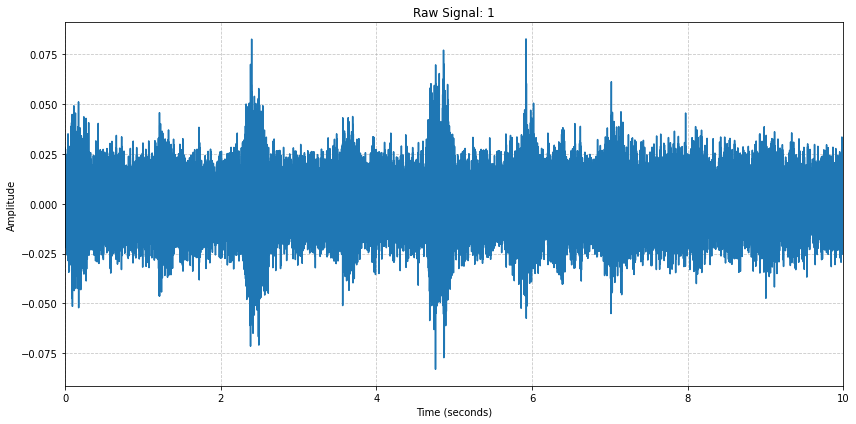

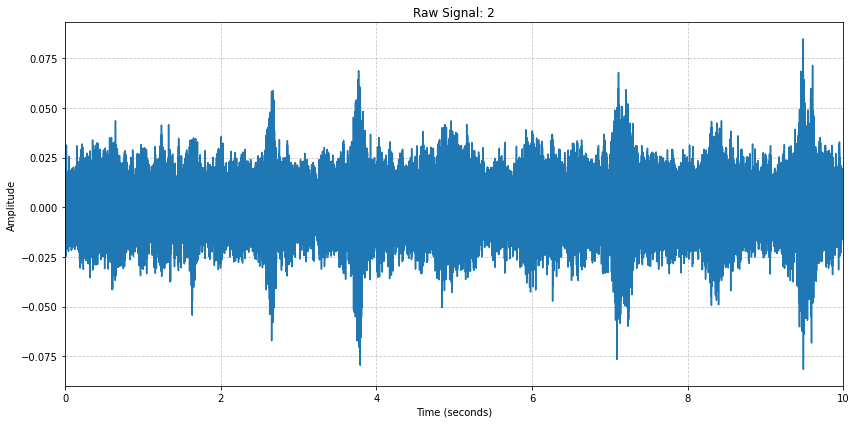

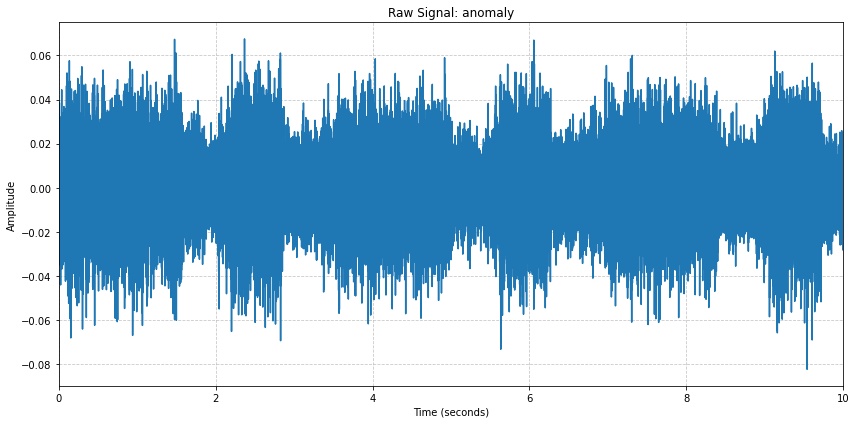

In [43]:
for key in (data.keys()):
    plot_raw_signal(data[key],key)

## STEP 2 : Visualize Spectogram

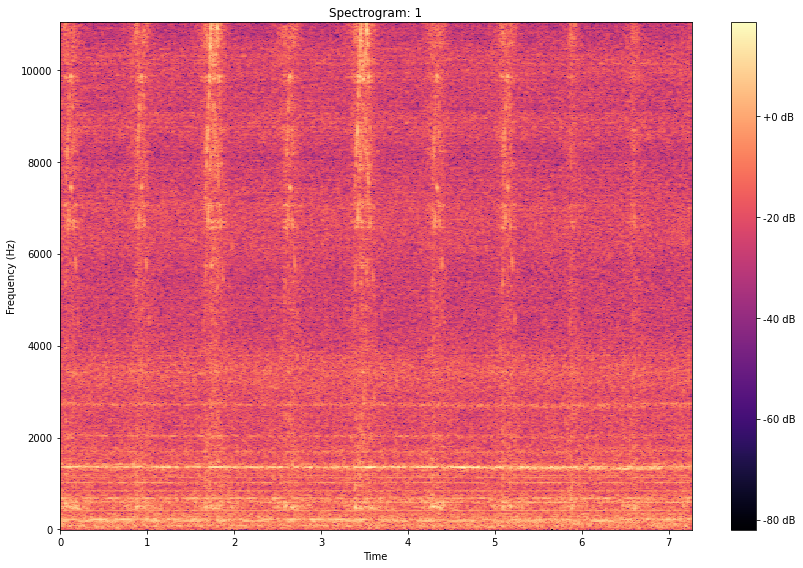

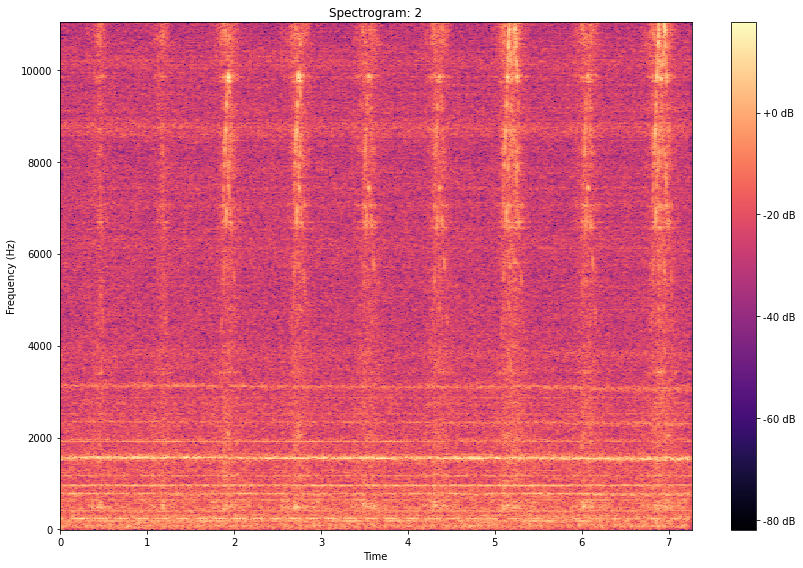

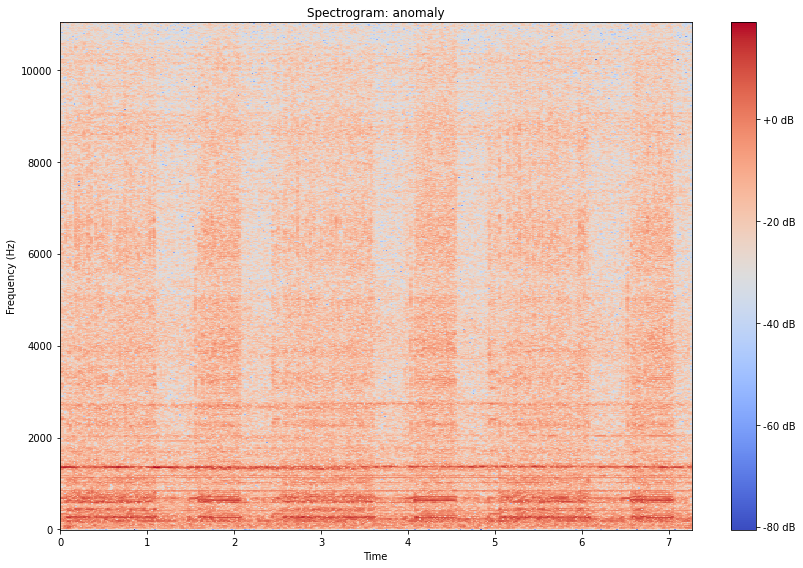

In [44]:
for key in (data.keys()):
    plot_spectrogram(data[key],key)

## STEP 3 : Visualize Mel Spectogram 

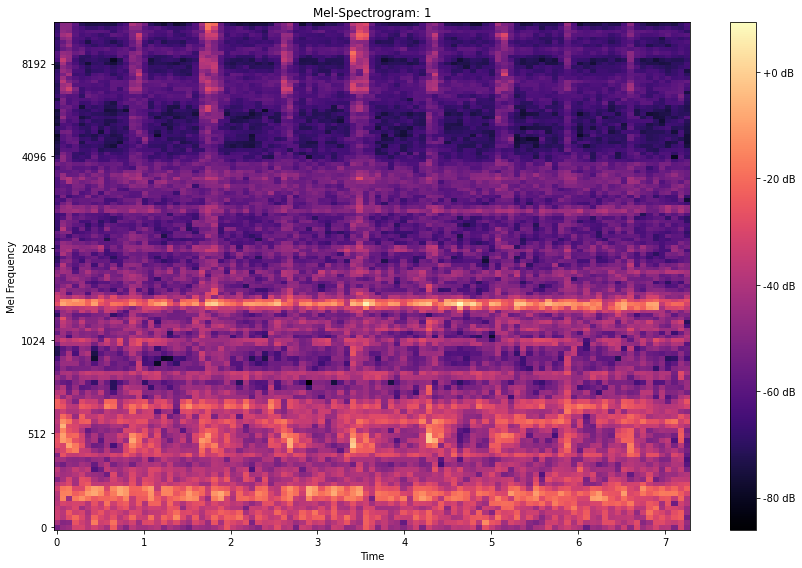

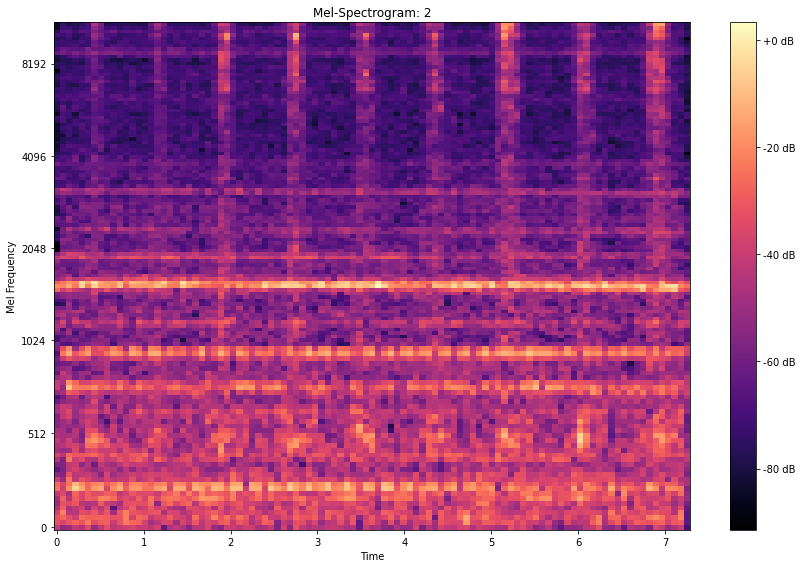

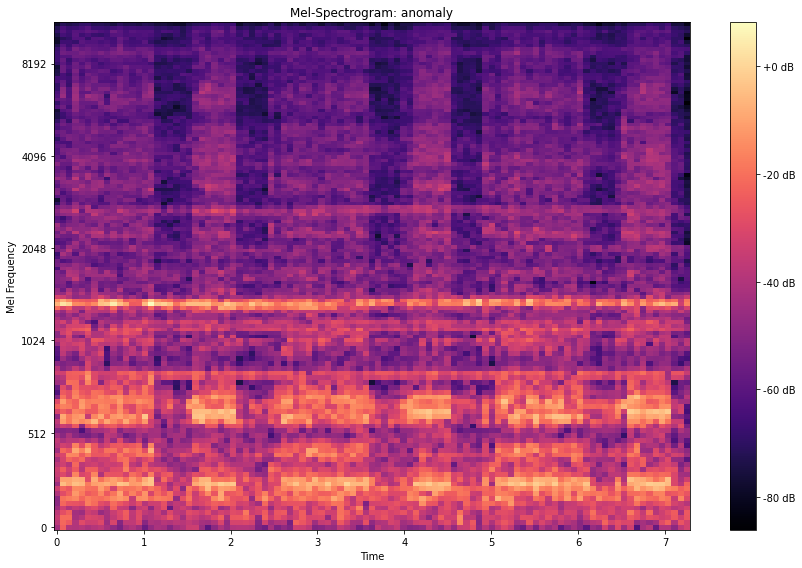

In [45]:
for key in (data.keys()):
    plot_mel_spectrogram(data[key],key)

## STEP 4 : Get Statistics of all signals

### Compare Mean

In [46]:
for key in (data.keys()):
    print(f'Mean signal_{key}')
    print(mean_signal(data[key]))

Mean signal_1
4.109764e-06
Mean signal_2
-2.6115417e-06
Mean signal_anomaly
-1.8024444e-07


### Compare Standard deviation

In [47]:
for key in (data.keys()):
    print(f'Std signal_{key}')
    print(std_signal(data[key]))

Std signal_1
0.011508592
Std signal_2
0.011504672
Std signal_anomaly
0.0147968065


### Compare Peak 2 Peak :  2*Amplitude

In [48]:
for key in (data.keys()):
    print(f'Pic to pic signal_{key}')
    print(pic_2_pic_signal(data[key]))

Pic to pic signal_1
0.165802
Pic to pic signal_2
0.16629028
Pic to pic signal_anomaly
0.14987183


### Compare Kurtosis

In [49]:
for key in (data.keys()):
    print(f'Kurtosis signal_{key}')
    print(kurtosis_signal(data[key]))

Kurtosis signal_1
1.0053404678747357
Kurtosis signal_2
1.0111544856149033
Kurtosis signal_anomaly
0.4353564924844009


### Compare skewness

In [50]:
for key in (data.keys()):
    print(f'Asymetry signal_{key}')
    print(asymetry_signal(data[key]))

Asymetry signal_1
0.005562194149457515
Asymetry signal_2
-0.028932449269212082
Asymetry signal_anomaly
-0.0505687041144749


### Compare histogram

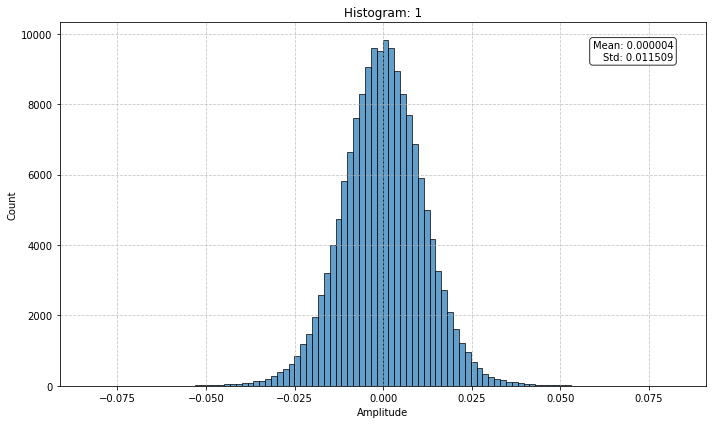

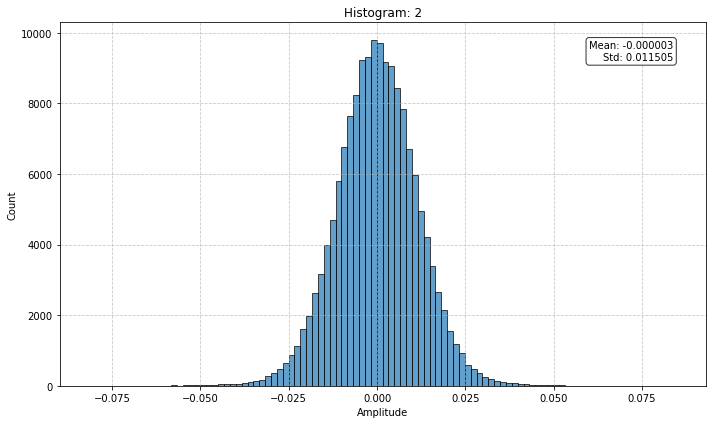

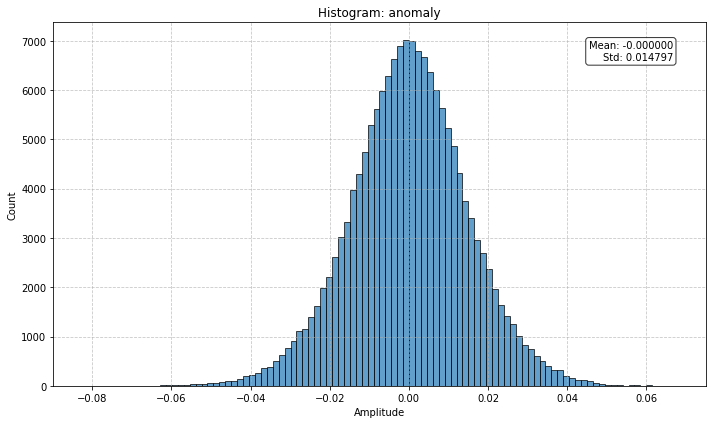

In [51]:
for key in (data.keys()):
    plot_hist_signal(data[key],key)